# Supernova Signal - WFSim

Create waveform simulator instruction file based on a supernova model.

```
Created : October 2021
Last Update : 11-11-2021
Melih Kara kara@kit.edu
Ricardo Peres
```

**ToDo**<br>
Recoil spectra sampling is pretty sparse and sampling from that gives discrete values. Interpolate the final spectra and sample from that.

## Table of Contents
- None

In [1]:
# allows to import from the parent directory
import sys; sys.path.append('../')

from snx import *
from snx.SN_plotter import Plotter
from snx.Supernova_Models import SN_lightcurve
from snx import sn_utils_plots.

*** Detector definition message ***
You are currently using the default XENON10 template detector.



In [2]:
M30sn_model  = SN_lightcurve(progenitor_mass = 30,
                             metallicity= 0.02,
                             time_of_revival = 100, 
                             distance = 10)

M30sn_model.get_recoil_spectra1D()
M30sn_model.get_recoil_spectra2D()

Retrieving object /dali/lgrandi/melih/mma/data/Object_M30-Z0.02_dist10.p
Object was found! 
To save manually: save_object(filename, update=True)

Retrieving object /dali/lgrandi/melih/mma/data/Object_M30-Z0.02_dist10_Er0.0-20.0_t0-0-tf-10_1D.p
Retrieving object /dali/lgrandi/melih/mma/data/Object_M30-Z0.02_dist10_Er0.0-15.5_step1_dist10_2D.p


Worked!


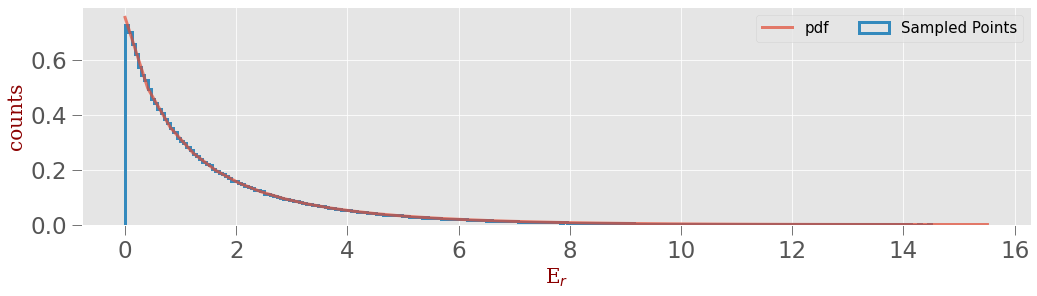

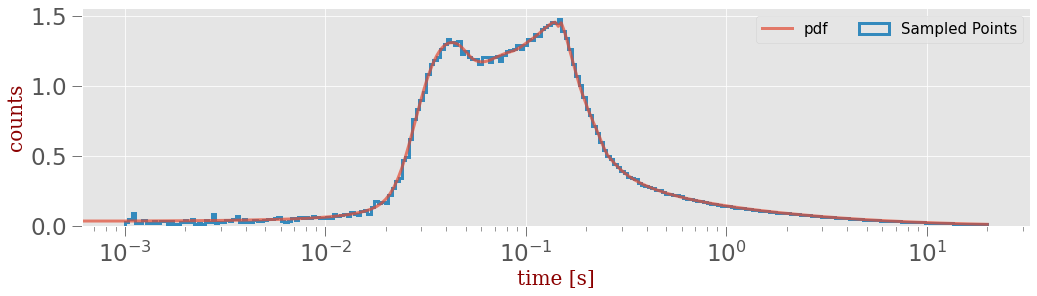

In [19]:
plotter = Plotter(M30sn_model)
fig, ax, samples = plotter.plot_sampled_energies()
plotter.plot_sampled_energies(x='time', xscale='log');

#### Object attributes

In [3]:
tot_rates1D = M30sn_model.total_rate1D # integrated(summed) between 0-10s 
tot_rates2D = M30sn_model.total_rate2D
recoil_energy_bins = M30sn_model.recoil_en
timebins = M30sn_model.t
nu_energies = M30sn_model.mean_E
rates_Er, rates_t = M30sn_model._get_1Drates_from2D()

The `sample_from_recoil_spectrum` can return 0 values, which might be a problem, as there would be no signal at these times (or worse, at negative times.)

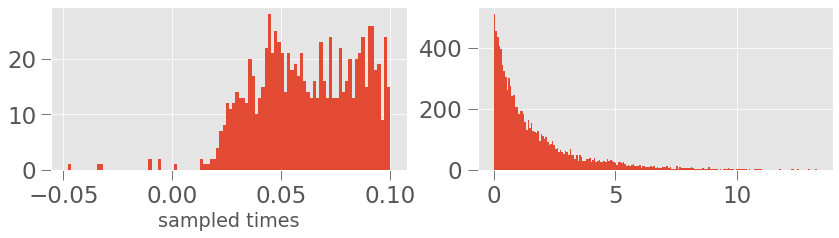

In [4]:
sample_t = sn_utils.sample_from_recoil_spectrum(x='time',N_sample=10000)
sample_E = sn_utils.sample_from_recoil_spectrum(N_sample=10000)
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14,3))
ax1.hist(sample_t, range=(min(sample_t),0.1), bins=100);
ax1.set_xlabel('sampled times');
ax2.hist(sample_E, bins=200);

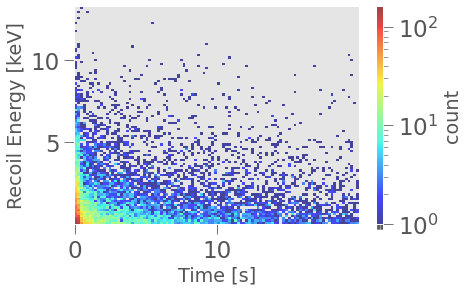

In [5]:
kwargs = dict(norm=LogNorm(), bins=100) # range=[[0, 3_000], [0, 20_000]],

mh_cut = mh.Histdd(sample_t, sample_E, **kwargs)

mh_cut.plot(log_scale=True,
            cblabel='count',
            cmap=plt.get_cmap('jet'),
            alpha=0.7,  colorbar_kwargs=dict(orientation="vertical", 
                                             pad=0.05,
                                             aspect=30, 
                                             fraction=0.1));
plt.ylabel('Recoil Energy [keV]')
plt.xlabel('Time [s]');

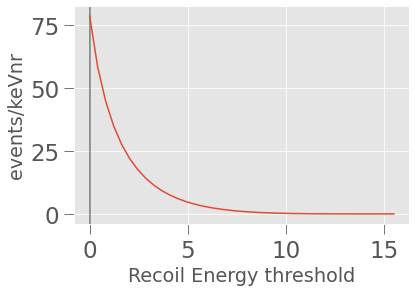

In [6]:
E_thr, rec_bins = sn_utils.get_rates_above_threshold(rates_Er['Total'], recoil_energy_bins)

plt.axvline(0, color='k', alpha=0.5);
plt.plot(rec_bins, E_thr*4.7);
plt.ylabel('events/keVnr');
plt.xlabel('Recoil Energy threshold');

Take the fiducial volume as 4.7 tonnes for now. There should be ~75 events in total.

---
## Import WFSim

In [7]:
versions_str = straxen.print_versions(('strax','straxen','cutax','wfsim'), return_string=True)
straxen.print_versions(('strax','straxen','cutax','wfsim'))

Working on midway2-0462.rcc.local with the following versions and installation paths:
python	v3.8.12	(default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
strax	v1.1.1	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/strax
straxen	v1.1.2	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/straxen
cutax	v1.0.0	/dali/lgrandi/xenonnt/software/cutax/latest/cutax
wfsim	v0.5.9	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/wfsim


In [8]:
# wfsim.instruction_dtype

Based on nest's naming convention [here](https://github.com/XENONnT/WFSim/blob/2c614b0f7b0d7c7adc516f6188e281857e8d7e22/wfsim/core.py#L22)

Ricardo's script for instruction generation https://github.com/XENONnT/analysiscode/blob/master/S2_shape_width/simulation/make_submit_files.py

In [9]:
nr_SNevents_perton = E_thr[0]
nr_SNevents_perton

16.738658904861552

In [13]:
tenk_instructions = sn_utils.instructions_SN(100_000, nr_SNevents_perton, dump_csv=True, filename='SN_wfsim_instructions_100k.csv')

generating instructions from nest:   0%|          | 0/100014 [00:00<?, ?it/s]

Saved in -> /dali/lgrandi/melih/sn_wfsim/instructions/SN_wfsim_instructions_100k.csv


In [16]:
single_instr = sn_utils.instructions_SN(1, nr_SNevents_perton, single=True, dump_csv=True, filename='SN_wfsim_instructions_single.csv')

generating instructions from nest:   0%|          | 0/79 [00:00<?, ?it/s]

Saved in -> /dali/lgrandi/melih/sn_wfsim/instructions/SN_wfsim_instructions_single.csv


In [16]:
# clean_repos()
sn_utils.see_repos()


 >>Instructions

single_SN.csv
SN_wfsim_instructions_single.csv
SN_wfsim_instructions_10k.csv
SN_wfsim_instructions_100k.csv
SN_wfsim_instructions.csv

 >>Logs

wfsim_high-stat.out
wfsim_high-stat.err

 >>Existing data

sn_simple-truth-my4gxfhotd
sn_simple-raw_records_he-my4gxfhotd
sn_simple-raw_records_aqmon-my4gxfhotd
sn_simple-raw_records-my4gxfhotd
sn_simple-peaklets-bie4dbe7uq
sn_simple-peaklet_classification-zx5hnlbcxi
sn_simple-peak_proximity-ms2awbcenc
sn_simple-peak_proximity-kyxbh64kup
sn_simple-peak_positions_mlp-trboz276tl
sn_simple-peak_positions_gcn-kjccspojaq
sn_simple-peak_positions_cnn-gzc3ptv4wd
sn_simple-peak_basics-qx25yaesdk
sn_simple-merged_s2s-wb6turax6q
sn_simple-lone_hits-bie4dbe7uq
sn_simple-event_positions-4fnlquguxu
sn_simple-event_positions-27zms63dso
sn_simple-event_info-hbuc3jrqss
sn_simple-event_info-b2pyr5zdyi
sn_simple-event_basics-fpmdg4cuhd
sn_simple-event_basics-cuklgxp2na
sn_simple-corrected_areas-wruohork3z
sn_simple-corrected_areas-i4vm62cwbg
SN

In [21]:
paths

{'img': '/dali/lgrandi/melih/mma/imgs/',
 'data': '/dali/lgrandi/melih/mma/data/'}

In [11]:
sn_utils.display_config()

      xenonnt       
field
volume
lxe_density
drift_field
---------------
       paths        
imgs
data
---------------
       strax        
exclude_tags
---------------
       wfsim        
instruction_path
logs_path
strax_data_path
---------------


In [12]:
st = cutax.contexts.xenonnt_sim_SR0v0_cmt_v5(output_folder=f'{config["wfsim"]["strax_data_path"]}')
st.set_config(dict(fax_config_override=dict(field_distortion_on=False)))
st.set_config(dict(fax_file=f'{config["wfsim"]["instruction_path"]}SN_wfsim_instructions_single.csv'))
rid = 'SN_wfsimdata_01'
for kind in ['truth', 'raw_records', 'peaks']:
    click.echo(f'{kind:15s} is {click.style(" stored ", bold=True, bg="green") if st.is_stored(rid, kind) else click.style(" not stored ",bold=True,bg="red")}')

truth           is  stored 
raw_records     is  stored 
peaks           is  not stored 


In [13]:
df = st.get_df(rid,'event_info')
truth = st.get_df(rid,'truth')
peak_basics = st.get_df(rid, 'peak_basics')
event_info = st.get_df(rid, 'event_info')

Loading event_info: |          | 0.00 % [00:00<?]

Loading truth: |          | 0.00 % [00:00<?]

Loading peak_basics: |          | 0.00 % [00:00<?]

Loading event_info: |          | 0.00 % [00:00<?]

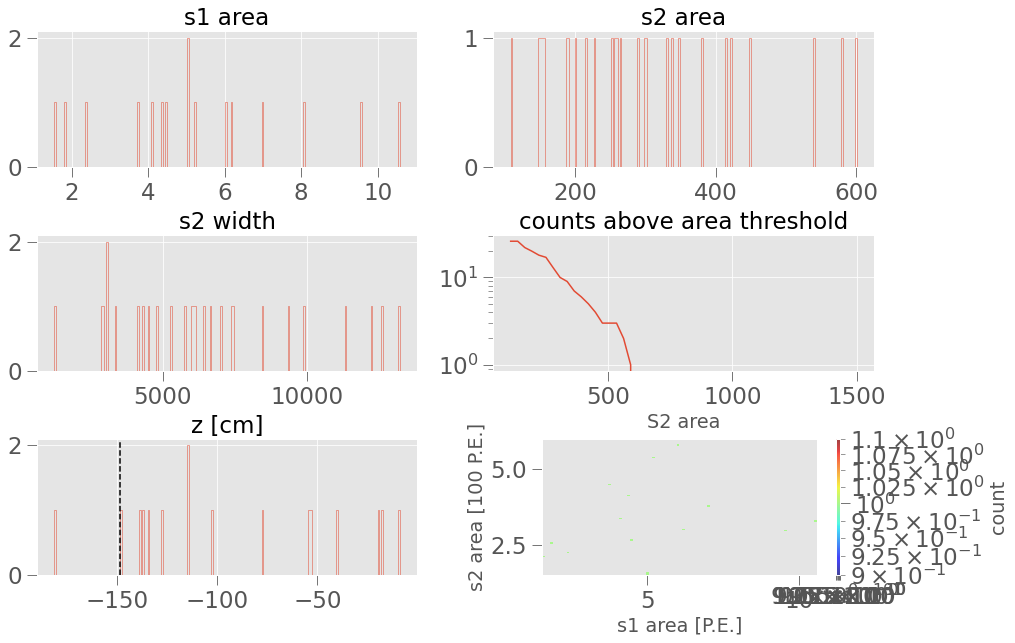

In [17]:
sn_utils_plots.quality_plot(event_info)

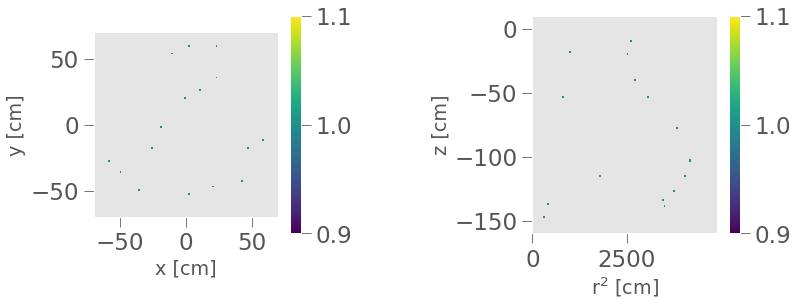

In [18]:
sn_utils_plots.plot_xy_rz(event_info)

In [51]:
st.data_info('event_info')['Field name'].values

array(['time', 'endtime', 'cs1', 'cs2_wo_elifecorr',
       'cs2_area_fraction_top', 'cs2_bottom', 'cs2', 'alt_cs1',
       'alt_cs2_wo_elifecorr', 'alt_cs2_area_fraction_top',
       'alt_cs2_bottom', 'alt_cs2', 'e_light', 'e_charge', 'e_ces',
       'n_peaks', 'drift_time', 'event_number', 's1_index',
       'alt_s1_index', 's1_time', 'alt_s1_time', 's1_center_time',
       'alt_s1_center_time', 's1_endtime', 'alt_s1_endtime', 's1_area',
       'alt_s1_area', 's1_n_channels', 'alt_s1_n_channels',
       's1_n_competing', 'alt_s1_n_competing', 's1_max_pmt',
       'alt_s1_max_pmt', 's1_max_pmt_area', 'alt_s1_max_pmt_area',
       's1_range_50p_area', 'alt_s1_range_50p_area', 's1_range_90p_area',
       'alt_s1_range_90p_area', 's1_rise_time', 'alt_s1_rise_time',
       's1_area_fraction_top', 'alt_s1_area_fraction_top',
       's1_tight_coincidence', 'alt_s1_tight_coincidence',
       's1_n_saturated_channels', 'alt_s1_n_saturated_channels',
       's1_tight_coincidence_channel', 'alt

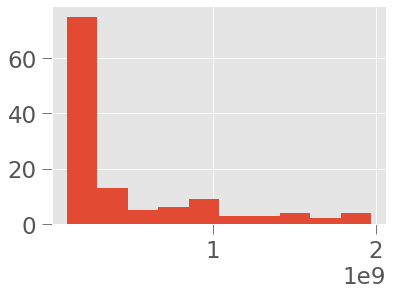

In [53]:
plt.hist(truth['time']);

---